# Exploring meta-data

In [12]:
import os
import re
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from sklearn.model_selection import train_test_split
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [2]:
DATA_DIR = "../data/Grain-Data-RGB"

In [3]:
def load_and_clean_files(files_dir):
    files = os.listdir(files_dir)
    if ".DS_Store" in files:
        files.remove(".DS_Store")
    return files

def extract_metadata(filename):
    """
    Extracts metadata from filename
    """
    grain_match = re.search(r"grain(?P<grainID>\d+)", filename)
    var_match   = re.search(r"var(?P<varietyNumber>\d+)", filename)
    micro_match = re.search(r"x(?P<x>\d+)y(?P<y>\d+)", filename)
    time_match  = re.search(
        r"2x_(?P<year>\d{4})-(?P<month>\d{2})-(?P<day>\d{2})T(?P<timestamp>\d+)_corr",
        filename
    )

    if not all([grain_match, var_match, micro_match, time_match]):
        return None

    return {
        "grainID": grain_match.group("grainID"),
        "varietyNumber": var_match.group("varietyNumber"),
        "microplotID": f"x{micro_match.group('x')}y{micro_match.group('y')}",
        "year": time_match.group("year"),
        "month": time_match.group("month"),
        "day": time_match.group("day"),
        "timestamp": time_match.group("timestamp"),
        "filename": filename
    }


In [4]:
# Load data files
data_files_rgb = load_and_clean_files(DATA_DIR + '/Grain-Data-RGB')

In [5]:
# Extract metadata from filenames
all_metadata = [extract_metadata(file) for file in data_files_rgb if extract_metadata(file)]

In [6]:
# convert metadata to pandas dataframe
df = pd.DataFrame(all_metadata)
df

,grainID,varietyNumber,microplotID,year,month,day,timestamp,filename
0,23632,7,x72y15,2021,10,23,144229,grain23632_var7-x72y15_7000_us_2x_2021-10-23T1...
1,7795,6,x40y20,2020,12,02,134036,grain7795_x40y20-var6_8000_us_2x_2020-12-02T13...
2,7511,5,x39y20,2020,12,02,131556,grain7511_x39y20-var5_8000_us_2x_2020-12-02T13...
3,16801,2,x76y12,2021,10,19,160332,grain16801_var2-x76y12_7000_us_2x_2021-10-19T1...
4,7613,5,x39y20,2020,12,02,132032,grain7613_x39y20-var5_8000_us_2x_2020-12-02T13...
...,...,...,...,...,...,...,...,...
26877,23093,6,x80y20,2021,10,19,150717,grain23093_var6-x80y20_7000_us_2x_2021-10-19T1...
26878,18368,3,x81y18,2021,10,23,150202,grain18368_var3-x81y18_7000_us_2x_2021-10-23T1...
26879,15566,2,x73y16,2021,10,19,155300,grain15566_var2-x73y16_7000_us_2x_2021-10-19T1...
26880,14254,1,x73y14,2021,10,23,151816,grain14254_var1-x73y14_7000_us_2x_2021-10-23T1...


# Exploring data
Loading random data files and visualizing them

In [7]:
def load_data(dir, filename):
    return np.load(os.path.join(dir, filename))

def band_brightness_npz(cube, k):
    """Approximation of the original Spectralon normalization."""
    band = cube[:, :, k]
    # avoid division by zero
    return np.mean(band) if np.mean(band) != 0 else 1.0


def plot_random_data(files, dir):
    N = 2
    sample_files = random.sample(files, N)
    cols = 5                   
    rows = math.ceil(N / cols) 

    plt.figure(figsize=(cols * 1.0, rows * 1.0))

    for i, f in enumerate(sample_files, 0):
        data = load_data(dir=dir, filename=f)
        img = data["x"]
        # Apply per-band brightness correction
        r = img[:, :, 0] / band_brightness_npz(img, 0)
        g = img[:, :, 1] / band_brightness_npz(img, 1)
        b = img[:, :, 2] / band_brightness_npz(img, 2)
        img = np.dstack((b, g, r))
        y = data["y"]


        # Normalize per image
        vmin, vmax = img.min(), img.max()
        if vmax > vmin:
            img_norm = (img - vmin) / (vmax - vmin)
        else:
            img_norm = np.zeros_like(img)

        plt.subplot(rows, cols, i + 1)
        plt.imshow(img_norm)
        plt.axis("off")

    plt.tight_layout(pad=0.1)
    plt.show()


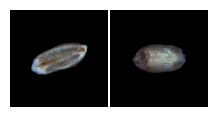

In [8]:
plot_random_data(files=data_files_rgb, dir=DATA_DIR+ '/Grain-Data-RGB')

In [11]:
# Separate data by year
df_2020 = df[df['year'] == "2020"]
df_2021 = df[df['year'] == "2021"]

# Save to separate CSV files
df_2020.to_csv('../data/Grain-Data-RGB-2020.csv', index=False)
df_2021.to_csv('../data/Grain-Data-RGB-2021.csv', index=False)

In [10]:
df.head()

,grainID,varietyNumber,microplotID,year,month,day,timestamp,filename
0,23632,7,x72y15,2021,10,23,144229,grain23632_var7-x72y15_7000_us_2x_2021-10-23T1...
1,7795,6,x40y20,2020,12,02,134036,grain7795_x40y20-var6_8000_us_2x_2020-12-02T13...
2,7511,5,x39y20,2020,12,02,131556,grain7511_x39y20-var5_8000_us_2x_2020-12-02T13...
3,16801,2,x76y12,2021,10,19,160332,grain16801_var2-x76y12_7000_us_2x_2021-10-19T1...
4,7613,5,x39y20,2020,12,02,132032,grain7613_x39y20-var5_8000_us_2x_2020-12-02T13...


### 2020 Data and ResNet18 Baseline

In [13]:
# Filter 2020 data and split into train (75%) and test (25%)
df_2020 = df[df['year'] == "2020"].reset_index(drop=True)

train_df, test_df = train_test_split(
    df_2020, 
    test_size=0.25, 
    random_state=42, 
    stratify=df_2020['varietyNumber']  # Stratify by variety to ensure balanced classes
)

print(f"Total 2020 samples: {len(df_2020)}")
print(f"Training samples: {len(train_df)} (75%)")
print(f"Test samples: {len(test_df)} (25%)")
print(f"\nClass distribution in training set:")
print(train_df['varietyNumber'].value_counts().sort_index())

Total 2020 samples: 13611
Training samples: 10208 (75%)
Test samples: 3403 (25%)

Class distribution in training set:
varietyNumber
1    1312
2    1585
3    1308
4    1250
5    1080
6    1249
7    1189
8    1235
Name: count, dtype: int64


In [20]:
class GrainDataset(Dataset):
    def __init__(self, dataframe, data_dir, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.data_dir = data_dir
        self.transform = transform
        # Create label mapping (varietyNumber 1-8 -> 0-7)
        self.label_map = {str(i): i-1 for i in range(1, 9)}
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        filename = row['filename']
        
        # Load npz file
        data = np.load(os.path.join(self.data_dir, filename))
        img = data['x'].astype(np.float32)
        
        # Apply per-band brightness normalization
        for k in range(3):
            band_mean = np.mean(img[:, :, k])
            if band_mean != 0:
                img[:, :, k] = img[:, :, k] / band_mean
        
        # Reorder BGR to RGB and normalize to [0, 1]
        img = img[:, :, ::-1].copy()  # BGR -> RGB
        vmin, vmax = img.min(), img.max()
        if vmax > vmin:
            img = (img - vmin) / (vmax - vmin)
        
        # Convert to tensor (C, H, W)
        img = torch.from_numpy(img).permute(2, 0, 1)
        
        if self.transform:
            img = self.transform(img)
        
        # Get label
        label = self.label_map[row['varietyNumber']]
        
        return img, label

In [21]:
# Define transforms for training (with augmentation) and testing
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
RGB_DATA_DIR = DATA_DIR + '/Grain-Data-RGB'
train_dataset = GrainDataset(train_df, RGB_DATA_DIR, transform=train_transform)
test_dataset = GrainDataset(test_df, RGB_DATA_DIR, transform=test_transform)

# Create dataloaders
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of test batches: {len(test_loader)}")

Number of training batches: 319
Number of test batches: 107


In [22]:
# Create models directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

# Create ResNet18 with pretrained ImageNet weights (Transfer Learning)
NUM_CLASSES = 8  # 8 grain varieties
NUM_EPOCHS = 20  # Define here for scheduler

model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)  # Pretrained weights

# Freeze early layers (optional - comment out to fine-tune all layers)
# for param in model.parameters():
#     param.requires_grad = False

# Replace final layer for our 8 classes
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
model = model.to(device)

# Loss function and optimizer with weight decay
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

# Cosine annealing scheduler for smooth learning rate decay
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=1e-6)

print(f"Model: ResNet18 (Transfer Learning - ImageNet pretrained)")
print(f"Optimizer: AdamW with weight_decay=0.01")
print(f"Scheduler: CosineAnnealingLR (T_max={NUM_EPOCHS})")
print(f"Number of parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/olutolaoloruntobipaul/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:03<00:00, 14.7MB/s]


Model: ResNet18 (Transfer Learning - ImageNet pretrained)
Optimizer: AdamW with weight_decay=0.01
Scheduler: CosineAnnealingLR (T_max=20)
Number of parameters: 11,180,616
Trainable parameters: 11,180,616


In [23]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in tqdm(dataloader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

In [24]:
# Training loop
best_acc = 0.0
history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': [], 'lr': []}

print("Starting training ResNet18 with Transfer Learning...")
print("=" * 60)

for epoch in range(NUM_EPOCHS):
    current_lr = optimizer.param_groups[0]['lr']
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS} | LR: {current_lr:.6f}")
    
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    
    scheduler.step()
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_acc)
    history['lr'].append(current_lr)
    
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Test Loss:  {test_loss:.4f} | Test Acc:  {test_acc:.2f}%")
    
    # Save best model
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), '../models/resnet18_transfer_best.pth')
        print(f">>> New best model saved with accuracy: {best_acc:.2f}%")

print("\n" + "=" * 60)
print(f"Training complete! Best test accuracy: {best_acc:.2f}%")

Starting training ResNet18 with Transfer Learning...

Epoch 1/20 | LR: 0.001000


Evaluating: 100%|██████████| 107/107 [00:14<00:00,  7.39it/s]


Train Loss: 1.3606 | Train Acc: 44.87%
Test Loss:  1.1582 | Test Acc:  55.45%
>>> New best model saved with accuracy: 55.45%

Epoch 2/20 | LR: 0.000994


Evaluating: 100%|██████████| 107/107 [00:14<00:00,  7.42it/s]


Train Loss: 1.0882 | Train Acc: 56.85%
Test Loss:  2.1235 | Test Acc:  42.34%

Epoch 3/20 | LR: 0.000976


Evaluating: 100%|██████████| 107/107 [00:14<00:00,  7.50it/s]


Train Loss: 0.9851 | Train Acc: 61.65%
Test Loss:  6.1592 | Test Acc:  22.51%

Epoch 4/20 | LR: 0.000946


Evaluating: 100%|██████████| 107/107 [00:17<00:00,  6.20it/s]


Train Loss: 0.9137 | Train Acc: 64.74%
Test Loss:  1.4655 | Test Acc:  49.52%

Epoch 5/20 | LR: 0.000905


Evaluating: 100%|██████████| 107/107 [00:17<00:00,  6.07it/s]


Train Loss: 0.8312 | Train Acc: 67.98%
Test Loss:  2.2574 | Test Acc:  39.05%

Epoch 6/20 | LR: 0.000854


Evaluating: 100%|██████████| 107/107 [00:13<00:00,  7.66it/s]


Train Loss: 0.7651 | Train Acc: 70.75%
Test Loss:  2.1823 | Test Acc:  40.93%

Epoch 7/20 | LR: 0.000794


Evaluating: 100%|██████████| 107/107 [00:14<00:00,  7.31it/s]


Train Loss: 0.7087 | Train Acc: 73.67%
Test Loss:  1.6260 | Test Acc:  47.43%

Epoch 8/20 | LR: 0.000727


Evaluating: 100%|██████████| 107/107 [00:13<00:00,  7.65it/s]


Train Loss: 0.6608 | Train Acc: 75.43%
Test Loss:  0.8655 | Test Acc:  69.17%
>>> New best model saved with accuracy: 69.17%

Epoch 9/20 | LR: 0.000655


Evaluating: 100%|██████████| 107/107 [00:14<00:00,  7.62it/s]


Train Loss: 0.6145 | Train Acc: 76.97%
Test Loss:  0.8293 | Test Acc:  69.79%
>>> New best model saved with accuracy: 69.79%

Epoch 10/20 | LR: 0.000579


Evaluating: 100%|██████████| 107/107 [00:14<00:00,  7.49it/s]


Train Loss: 0.5563 | Train Acc: 79.43%
Test Loss:  0.6799 | Test Acc:  74.85%
>>> New best model saved with accuracy: 74.85%

Epoch 11/20 | LR: 0.000501


Evaluating: 100%|██████████| 107/107 [00:14<00:00,  7.59it/s]


Train Loss: 0.4953 | Train Acc: 81.96%
Test Loss:  0.6898 | Test Acc:  75.61%
>>> New best model saved with accuracy: 75.61%

Epoch 12/20 | LR: 0.000422


Evaluating: 100%|██████████| 107/107 [00:14<00:00,  7.60it/s]


Train Loss: 0.4462 | Train Acc: 83.42%
Test Loss:  17.3115 | Test Acc:  16.75%

Epoch 13/20 | LR: 0.000346


Evaluating: 100%|██████████| 107/107 [00:14<00:00,  7.63it/s]


Train Loss: 0.3883 | Train Acc: 85.68%
Test Loss:  0.6828 | Test Acc:  76.67%
>>> New best model saved with accuracy: 76.67%

Epoch 14/20 | LR: 0.000274


Evaluating: 100%|██████████| 107/107 [00:13<00:00,  7.65it/s]


Train Loss: 0.3400 | Train Acc: 87.94%
Test Loss:  0.5947 | Test Acc:  79.55%
>>> New best model saved with accuracy: 79.55%

Epoch 15/20 | LR: 0.000207


Evaluating: 100%|██████████| 107/107 [00:14<00:00,  7.60it/s]


Train Loss: 0.2731 | Train Acc: 90.46%
Test Loss:  0.5701 | Test Acc:  81.63%
>>> New best model saved with accuracy: 81.63%

Epoch 16/20 | LR: 0.000147


Evaluating: 100%|██████████| 107/107 [00:14<00:00,  7.63it/s]


Train Loss: 0.2323 | Train Acc: 91.97%
Test Loss:  0.5540 | Test Acc:  81.87%
>>> New best model saved with accuracy: 81.87%

Epoch 17/20 | LR: 0.000096


Evaluating: 100%|██████████| 107/107 [00:14<00:00,  7.61it/s]


Train Loss: 0.1956 | Train Acc: 93.46%
Test Loss:  0.5823 | Test Acc:  81.84%

Epoch 18/20 | LR: 0.000055


Evaluating: 100%|██████████| 107/107 [00:13<00:00,  7.65it/s]


Train Loss: 0.1654 | Train Acc: 94.45%
Test Loss:  0.5724 | Test Acc:  82.25%
>>> New best model saved with accuracy: 82.25%

Epoch 19/20 | LR: 0.000025


Evaluating: 100%|██████████| 107/107 [00:14<00:00,  7.47it/s]


Train Loss: 0.1530 | Train Acc: 94.75%
Test Loss:  0.5522 | Test Acc:  82.66%
>>> New best model saved with accuracy: 82.66%

Epoch 20/20 | LR: 0.000007


Evaluating: 100%|██████████| 107/107 [00:13<00:00,  7.72it/s]


Train Loss: 0.1404 | Train Acc: 95.34%
Test Loss:  0.5568 | Test Acc:  82.96%
>>> New best model saved with accuracy: 82.96%

Training complete! Best test accuracy: 82.96%


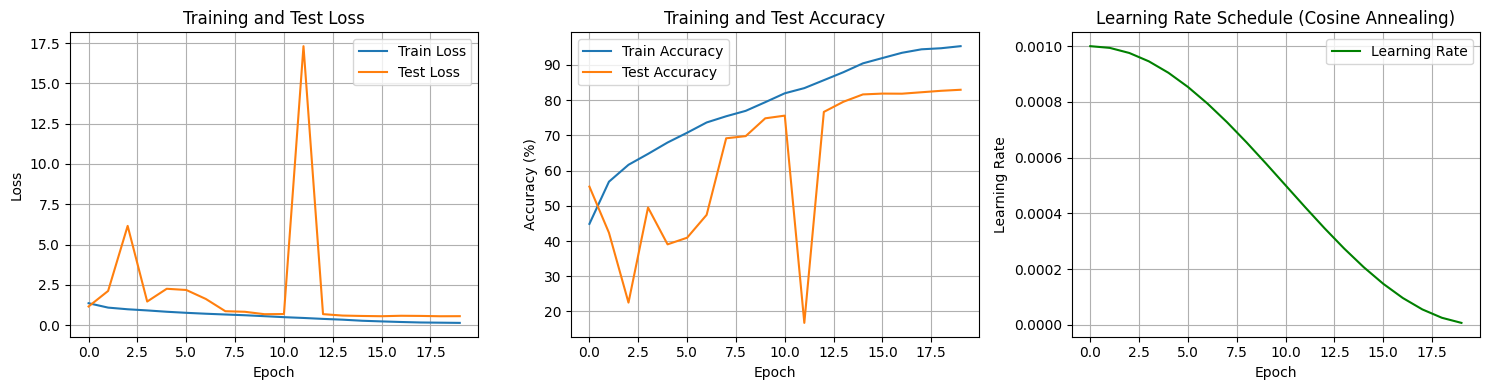


Final Results:
Best Test Accuracy: 82.96%
Final Train Accuracy: 95.34%
Final Test Accuracy: 82.96%


In [26]:
# Plot training history
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Loss plot
axes[0].plot(history['train_loss'], label='Train Loss')
axes[0].plot(history['test_loss'], label='Test Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Test Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy plot
axes[1].plot(history['train_acc'], label='Train Accuracy')
axes[1].plot(history['test_acc'], label='Test Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training and Test Accuracy')
axes[1].legend()
axes[1].grid(True)

# Learning rate plot
axes[2].plot(history['lr'], label='Learning Rate', color='green')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Learning Rate')
axes[2].set_title('Learning Rate Schedule (Cosine Annealing)')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.savefig('../models/resnet18_transfer_training_history.png', dpi=150)
plt.show()

print(f"\nFinal Results:")
print(f"Best Test Accuracy: {best_acc:.2f}%")
print(f"Final Train Accuracy: {history['train_acc'][-1]:.2f}%")
print(f"Final Test Accuracy: {history['test_acc'][-1]:.2f}%")

# APSNet: Adaptive Pyramid Scale Network for Grain Classification
# A tailored architecture combining vision backbone with domain-specific modules

In [36]:
import torch.nn.functional as F

# Check if we're using MPS (Apple Silicon)
IS_MPS = device.type == 'mps'

def mps_safe_adaptive_avg_pool2d(x, output_size):
    """MPS-safe adaptive average pooling - falls back to CPU if needed."""
    if IS_MPS:
        x_cpu = x.cpu()
        pooled = F.adaptive_avg_pool2d(x_cpu, output_size)
        return pooled.to(device)
    else:
        return F.adaptive_avg_pool2d(x, output_size)


class ScaleEmbedding(nn.Module):
    """Scale embedding module for grain size awareness."""
    def __init__(self, in_channels, embed_dim=128):
        super().__init__()
        self.pool_sizes = [1, 7]
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(in_channels, embed_dim // len(self.pool_sizes), 1, bias=False),
                nn.BatchNorm2d(embed_dim // len(self.pool_sizes)),
                nn.ReLU(inplace=True)
            )
            for _ in self.pool_sizes
        ])
        self.embed_dim = embed_dim
        
    def forward(self, x):
        B, C, H, W = x.shape
        scale_features = []
        for pool_size, conv in zip(self.pool_sizes, self.convs):
            pooled = mps_safe_adaptive_avg_pool2d(x, pool_size)
            projected = conv(pooled)
            upsampled = F.interpolate(projected, size=(H, W), mode='bilinear', align_corners=False)
            scale_features.append(upsampled)
        return torch.cat(scale_features, dim=1)


class CBAM(nn.Module):
    """Convolutional Block Attention Module - Channel + Spatial Attention."""
    def __init__(self, channels, reduction=16):
        super().__init__()
        # Channel attention
        self.channel_fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False)
        )
        # Spatial attention
        self.spatial_conv = nn.Sequential(
            nn.Conv2d(2, 1, kernel_size=7, padding=3, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        B, C, H, W = x.shape
        # Channel attention
        avg_pool = mps_safe_adaptive_avg_pool2d(x, 1).view(B, C)
        max_pool = F.adaptive_max_pool2d(x, 1).view(B, C)
        channel_att = torch.sigmoid(self.channel_fc(avg_pool) + self.channel_fc(max_pool))
        x = x * channel_att.view(B, C, 1, 1)
        # Spatial attention
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        spatial_att = self.spatial_conv(torch.cat([avg_out, max_out], dim=1))
        return x * spatial_att


class PyramidPoolingModule(nn.Module):
    """Pyramid Pooling Module for multi-scale context."""
    def __init__(self, in_channels, out_channels, pool_sizes=[1, 7]):
        super().__init__()
        self.pool_sizes = pool_sizes
        self.stages = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(in_channels, out_channels // len(pool_sizes), 1, bias=False),
                nn.BatchNorm2d(out_channels // len(pool_sizes)),
                nn.ReLU(inplace=True)
            )
            for _ in pool_sizes
        ])
        self.bottleneck = nn.Sequential(
            nn.Conv2d(in_channels + out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        H, W = x.shape[2:]
        pyramids = [x]
        for pool_size, stage in zip(self.pool_sizes, self.stages):
            pooled = mps_safe_adaptive_avg_pool2d(x, pool_size)
            projected = stage(pooled)
            upsampled = F.interpolate(projected, size=(H, W), mode='bilinear', align_corners=False)
            pyramids.append(upsampled)
        return self.bottleneck(torch.cat(pyramids, dim=1))


class APSNetV2(nn.Module):
    """
    APSNet V2 with ResNet50 backbone for higher capacity.
    
    Improvements over V1:
    - ResNet50 backbone (2048 channels vs 512)
    - CBAM attention module
    - Larger scale embedding
    - Deeper classification head
    """
    def __init__(self, num_classes=8, pretrained=True, freeze_early=True):
        super().__init__()
        
        # ResNet50 backbone (2048 output channels)
        base_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2 if pretrained else None)
        backbone_channels = 2048
        
        self.conv1 = base_model.conv1
        self.bn1 = base_model.bn1
        self.relu = base_model.relu
        self.maxpool = base_model.maxpool
        self.layer1 = base_model.layer1  # 256 channels
        self.layer2 = base_model.layer2  # 512 channels
        self.layer3 = base_model.layer3  # 1024 channels
        self.layer4 = base_model.layer4  # 2048 channels
        
        # Freeze early layers for stable training
        if freeze_early:
            for param in self.conv1.parameters():
                param.requires_grad = False
            for param in self.bn1.parameters():
                param.requires_grad = False
            for param in self.layer1.parameters():
                param.requires_grad = False
        
        # Domain-specific modules
        self.ppm = PyramidPoolingModule(backbone_channels, 512, pool_sizes=[1, 7])
        self.scale_embed = ScaleEmbedding(backbone_channels, embed_dim=128)
        self.cbam = CBAM(512 + 128, reduction=16)
        
        # Classification head with more capacity
        combined_channels = 512 + 128  # 640
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(combined_channels * 7 * 7, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        # Backbone
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)  # [B, 2048, 7, 7]
        
        # Domain-specific processing
        ppm_out = self.ppm(x)           # [B, 512, 7, 7]
        scale_out = self.scale_embed(x)  # [B, 128, 7, 7]
        
        combined = torch.cat([ppm_out, scale_out], dim=1)  # [B, 640, 7, 7]
        combined = self.cbam(combined)
        
        out = self.classifier(combined)
        return out


# Create APSNet V2 with ResNet50 backbone
apsnet_model = APSNetV2(num_classes=NUM_CLASSES, pretrained=True, freeze_early=True)
apsnet_model = apsnet_model.to(device)

print("APSNet V2 Architecture Summary:")
print("=" * 60)
print(f"Device: {device}")
print(f"Backbone: ResNet50 (ImageNet V2 pretrained)")
print(f"Backbone output: 2048 channels (vs 512 in ResNet18)")
print(f"Domain-specific modules:")
print(f"  - Pyramid Pooling Module (512 channels)")
print(f"  - Scale Embedding (128 channels)")
print(f"  - CBAM Attention (Channel + Spatial)")
print(f"  - Deep classifier (640->1024->256->8)")
print(f"\nTotal parameters: {sum(p.numel() for p in apsnet_model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in apsnet_model.parameters() if p.requires_grad):,}")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /Users/olutolaoloruntobipaul/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:06<00:00, 17.0MB/s]


APSNet V2 Architecture Summary:
Device: mps
Backbone: ResNet50 (ImageNet V2 pretrained)
Backbone output: 2048 channels (vs 512 in ResNet18)
Domain-specific modules:
  - Pyramid Pooling Module (512 channels)
  - Scale Embedding (128 channels)
  - CBAM Attention (Channel + Spatial)
  - Deep classifier (640->1024->256->8)

Total parameters: 69,049,514
Trainable parameters: 68,824,170


In [37]:
# APSNet V2 Training Setup with ResNet50
APSNET_EPOCHS = 30  # More epochs for larger model

# Separate frozen and trainable backbone params
trainable_backbone_params = list(apsnet_model.layer2.parameters()) + \
                            list(apsnet_model.layer3.parameters()) + \
                            list(apsnet_model.layer4.parameters())

domain_params = list(apsnet_model.ppm.parameters()) + \
                list(apsnet_model.scale_embed.parameters()) + \
                list(apsnet_model.cbam.parameters()) + \
                list(apsnet_model.classifier.parameters())

# Different learning rates for backbone vs domain modules
apsnet_optimizer = optim.AdamW([
    {'params': trainable_backbone_params, 'lr': 5e-5},   # Lower LR for pretrained layers
    {'params': domain_params, 'lr': 1e-3}                 # Higher LR for new layers
], weight_decay=0.02)

apsnet_criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# OneCycleLR for better convergence
steps_per_epoch = len(train_loader)
apsnet_scheduler = optim.lr_scheduler.OneCycleLR(
    apsnet_optimizer,
    max_lr=[5e-4, 1e-2],  # Peak LRs for each param group
    epochs=APSNET_EPOCHS,
    steps_per_epoch=steps_per_epoch,
    pct_start=0.1,  # 10% warmup
    anneal_strategy='cos'
)

print("APSNet V2 Training Configuration:")
print("=" * 60)
print(f"Epochs: {APSNET_EPOCHS}")
print(f"Backbone LR: 5e-5 -> 5e-4 (peak) | Domain LR: 1e-3 -> 1e-2 (peak)")
print(f"Weight decay: 0.02")
print(f"Loss: CrossEntropyLoss with label_smoothing=0.1")
print(f"Scheduler: OneCycleLR with 10% warmup")

APSNet V2 Training Configuration:
Epochs: 30
Backbone LR: 5e-5 -> 5e-4 (peak) | Domain LR: 1e-3 -> 1e-2 (peak)
Weight decay: 0.02
Loss: CrossEntropyLoss with label_smoothing=0.1
Scheduler: OneCycleLR with 10% warmup


In [38]:
# Modified training function for OneCycleLR (step per batch)
def train_epoch_with_scheduler(model, dataloader, criterion, optimizer, scheduler, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in tqdm(dataloader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        
        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        scheduler.step()  # Step scheduler per batch for OneCycleLR
        
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc


# APSNet V2 Training Loop
apsnet_best_acc = 0.0
apsnet_history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': [], 'lr': []}

print("Starting APSNet V2 Training (ResNet50 backbone)...")
print("=" * 60)

for epoch in range(APSNET_EPOCHS):
    # Get current learning rates
    backbone_lr = apsnet_optimizer.param_groups[0]['lr']
    domain_lr = apsnet_optimizer.param_groups[1]['lr']
    print(f"\nEpoch {epoch+1}/{APSNET_EPOCHS} | Backbone LR: {backbone_lr:.6f} | Domain LR: {domain_lr:.6f}")
    
    # Training with per-batch scheduler stepping
    train_loss, train_acc = train_epoch_with_scheduler(
        apsnet_model, train_loader, apsnet_criterion, apsnet_optimizer, apsnet_scheduler, device
    )
    
    # Evaluation
    test_loss, test_acc = evaluate(apsnet_model, test_loader, apsnet_criterion, device)
    
    # Record history
    apsnet_history['train_loss'].append(train_loss)
    apsnet_history['train_acc'].append(train_acc)
    apsnet_history['test_loss'].append(test_loss)
    apsnet_history['test_acc'].append(test_acc)
    apsnet_history['lr'].append(domain_lr)
    
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Test Loss:  {test_loss:.4f} | Test Acc:  {test_acc:.2f}%")
    
    # Save best model
    if test_acc > apsnet_best_acc:
        apsnet_best_acc = test_acc
        torch.save(apsnet_model.state_dict(), '../models/apsnet_v2_best.pth')
        print(f">>> New best APSNet V2 model saved with accuracy: {apsnet_best_acc:.2f}%")

print("\n" + "=" * 60)
print(f"APSNet V2 Training complete! Best test accuracy: {apsnet_best_acc:.2f}%")

Starting APSNet V2 Training (ResNet50 backbone)...

Epoch 1/30 | Backbone LR: 0.000020 | Domain LR: 0.000400


Evaluating: 100%|██████████| 107/107 [00:39<00:00,  2.71it/s]


Train Loss: 1.5754 | Train Acc: 44.74%
Test Loss:  1.6509 | Test Acc:  52.22%
>>> New best APSNet V2 model saved with accuracy: 52.22%

Epoch 2/30 | Backbone LR: 0.000140 | Domain LR: 0.002805


Evaluating: 100%|██████████| 107/107 [00:38<00:00,  2.77it/s]


Train Loss: 1.3851 | Train Acc: 56.88%
Test Loss:  1.5234 | Test Acc:  52.07%

Epoch 3/30 | Backbone LR: 0.000380 | Domain LR: 0.007609


Evaluating: 100%|██████████| 107/107 [00:39<00:00,  2.70it/s]


Train Loss: 1.2810 | Train Acc: 62.01%
Test Loss:  1.2183 | Test Acc:  64.06%
>>> New best APSNet V2 model saved with accuracy: 64.06%

Epoch 4/30 | Backbone LR: 0.000500 | Domain LR: 0.010000


Evaluating: 100%|██████████| 107/107 [02:00<00:00,  1.13s/it]


Train Loss: 1.1582 | Train Acc: 68.98%
Test Loss:  1.0927 | Test Acc:  71.55%
>>> New best APSNet V2 model saved with accuracy: 71.55%

Epoch 5/30 | Backbone LR: 0.000498 | Domain LR: 0.009966


Evaluating: 100%|██████████| 107/107 [00:28<00:00,  3.77it/s]


Train Loss: 1.0569 | Train Acc: 74.23%
Test Loss:  0.9915 | Test Acc:  75.26%
>>> New best APSNet V2 model saved with accuracy: 75.26%

Epoch 6/30 | Backbone LR: 0.000493 | Domain LR: 0.009865


Evaluating: 100%|██████████| 107/107 [00:28<00:00,  3.79it/s]


Train Loss: 1.0059 | Train Acc: 76.12%
Test Loss:  0.9865 | Test Acc:  75.55%
>>> New best APSNet V2 model saved with accuracy: 75.55%

Epoch 7/30 | Backbone LR: 0.000485 | Domain LR: 0.009698


Evaluating: 100%|██████████| 107/107 [00:27<00:00,  3.82it/s]


Train Loss: 0.9535 | Train Acc: 79.09%
Test Loss:  0.9277 | Test Acc:  79.22%
>>> New best APSNet V2 model saved with accuracy: 79.22%

Epoch 8/30 | Backbone LR: 0.000473 | Domain LR: 0.009467


Evaluating: 100%|██████████| 107/107 [00:27<00:00,  3.85it/s]


Train Loss: 0.8947 | Train Acc: 81.89%
Test Loss:  0.8828 | Test Acc:  81.28%
>>> New best APSNet V2 model saved with accuracy: 81.28%

Epoch 9/30 | Backbone LR: 0.000459 | Domain LR: 0.009176


Evaluating: 100%|██████████| 107/107 [00:28<00:00,  3.79it/s]


Train Loss: 0.8628 | Train Acc: 83.87%
Test Loss:  0.9041 | Test Acc:  80.05%

Epoch 10/30 | Backbone LR: 0.000441 | Domain LR: 0.008829


Evaluating: 100%|██████████| 107/107 [00:28<00:00,  3.76it/s]


Train Loss: 0.8352 | Train Acc: 84.56%
Test Loss:  0.9108 | Test Acc:  79.46%

Epoch 11/30 | Backbone LR: 0.000421 | Domain LR: 0.008430


Evaluating: 100%|██████████| 107/107 [00:28<00:00,  3.76it/s]


Train Loss: 0.7965 | Train Acc: 86.32%
Test Loss:  0.8656 | Test Acc:  81.16%

Epoch 12/30 | Backbone LR: 0.000399 | Domain LR: 0.007984


Evaluating: 100%|██████████| 107/107 [00:28<00:00,  3.80it/s]


Train Loss: 0.7621 | Train Acc: 87.91%
Test Loss:  0.8969 | Test Acc:  81.16%

Epoch 13/30 | Backbone LR: 0.000375 | Domain LR: 0.007498


Evaluating: 100%|██████████| 107/107 [00:31<00:00,  3.43it/s]


Train Loss: 0.7297 | Train Acc: 89.38%
Test Loss:  0.8370 | Test Acc:  83.40%
>>> New best APSNet V2 model saved with accuracy: 83.40%

Epoch 14/30 | Backbone LR: 0.000349 | Domain LR: 0.006979


Evaluating: 100%|██████████| 107/107 [00:28<00:00,  3.79it/s]


Train Loss: 0.7008 | Train Acc: 90.75%
Test Loss:  0.8340 | Test Acc:  83.98%
>>> New best APSNet V2 model saved with accuracy: 83.98%

Epoch 15/30 | Backbone LR: 0.000322 | Domain LR: 0.006432


Evaluating: 100%|██████████| 107/107 [00:28<00:00,  3.75it/s]


Train Loss: 0.6796 | Train Acc: 91.67%
Test Loss:  0.8209 | Test Acc:  84.87%
>>> New best APSNet V2 model saved with accuracy: 84.87%

Epoch 16/30 | Backbone LR: 0.000293 | Domain LR: 0.005866


Evaluating: 100%|██████████| 107/107 [00:29<00:00,  3.67it/s]


Train Loss: 0.6590 | Train Acc: 92.66%
Test Loss:  0.8233 | Test Acc:  84.51%

Epoch 17/30 | Backbone LR: 0.000264 | Domain LR: 0.005289


Evaluating: 100%|██████████| 107/107 [00:28<00:00,  3.79it/s]


Train Loss: 0.6260 | Train Acc: 94.18%
Test Loss:  0.8262 | Test Acc:  84.57%

Epoch 18/30 | Backbone LR: 0.000235 | Domain LR: 0.004707


Evaluating: 100%|██████████| 107/107 [00:28<00:00,  3.74it/s]


Train Loss: 0.6110 | Train Acc: 94.85%
Test Loss:  0.7850 | Test Acc:  85.98%
>>> New best APSNet V2 model saved with accuracy: 85.98%

Epoch 19/30 | Backbone LR: 0.000206 | Domain LR: 0.004130


Evaluating: 100%|██████████| 107/107 [00:28<00:00,  3.77it/s]


Train Loss: 0.5892 | Train Acc: 95.60%
Test Loss:  0.8020 | Test Acc:  85.92%

Epoch 20/30 | Backbone LR: 0.000178 | Domain LR: 0.003564


Evaluating: 100%|██████████| 107/107 [00:28<00:00,  3.82it/s]


Train Loss: 0.5706 | Train Acc: 96.47%
Test Loss:  0.7709 | Test Acc:  87.42%
>>> New best APSNet V2 model saved with accuracy: 87.42%

Epoch 21/30 | Backbone LR: 0.000151 | Domain LR: 0.003018


Evaluating: 100%|██████████| 107/107 [00:28<00:00,  3.76it/s]


Train Loss: 0.5552 | Train Acc: 97.28%
Test Loss:  0.7818 | Test Acc:  86.72%

Epoch 22/30 | Backbone LR: 0.000125 | Domain LR: 0.002498


Evaluating: 100%|██████████| 107/107 [00:28<00:00,  3.81it/s]


Train Loss: 0.5476 | Train Acc: 97.57%
Test Loss:  0.7897 | Test Acc:  86.75%

Epoch 23/30 | Backbone LR: 0.000101 | Domain LR: 0.002013


Evaluating: 100%|██████████| 107/107 [00:28<00:00,  3.81it/s]


Train Loss: 0.5314 | Train Acc: 98.06%
Test Loss:  0.7712 | Test Acc:  87.57%
>>> New best APSNet V2 model saved with accuracy: 87.57%

Epoch 24/30 | Backbone LR: 0.000078 | Domain LR: 0.001567


Evaluating: 100%|██████████| 107/107 [00:28<00:00,  3.82it/s]


Train Loss: 0.5231 | Train Acc: 98.54%
Test Loss:  0.7752 | Test Acc:  87.25%

Epoch 25/30 | Backbone LR: 0.000058 | Domain LR: 0.001169


Evaluating: 100%|██████████| 107/107 [00:28<00:00,  3.81it/s]


Train Loss: 0.5174 | Train Acc: 98.68%
Test Loss:  0.7754 | Test Acc:  87.16%

Epoch 26/30 | Backbone LR: 0.000041 | Domain LR: 0.000822


Evaluating: 100%|██████████| 107/107 [00:28<00:00,  3.81it/s]


Train Loss: 0.5089 | Train Acc: 99.13%
Test Loss:  0.7683 | Test Acc:  87.72%
>>> New best APSNet V2 model saved with accuracy: 87.72%

Epoch 27/30 | Backbone LR: 0.000027 | Domain LR: 0.000531


Evaluating: 100%|██████████| 107/107 [00:28<00:00,  3.81it/s]


Train Loss: 0.5069 | Train Acc: 99.08%
Test Loss:  0.7755 | Test Acc:  87.36%

Epoch 28/30 | Backbone LR: 0.000015 | Domain LR: 0.000301


Evaluating: 100%|██████████| 107/107 [00:28<00:00,  3.80it/s]


Train Loss: 0.5054 | Train Acc: 99.27%
Test Loss:  0.7625 | Test Acc:  88.10%
>>> New best APSNet V2 model saved with accuracy: 88.10%

Epoch 29/30 | Backbone LR: 0.000007 | Domain LR: 0.000134


Evaluating: 100%|██████████| 107/107 [00:28<00:00,  3.81it/s]


Train Loss: 0.5062 | Train Acc: 99.13%
Test Loss:  0.7655 | Test Acc:  87.48%

Epoch 30/30 | Backbone LR: 0.000002 | Domain LR: 0.000034


Evaluating: 100%|██████████| 107/107 [00:28<00:00,  3.76it/s]


Train Loss: 0.5051 | Train Acc: 99.25%
Test Loss:  0.7611 | Test Acc:  88.25%
>>> New best APSNet V2 model saved with accuracy: 88.25%

APSNet V2 Training complete! Best test accuracy: 88.25%


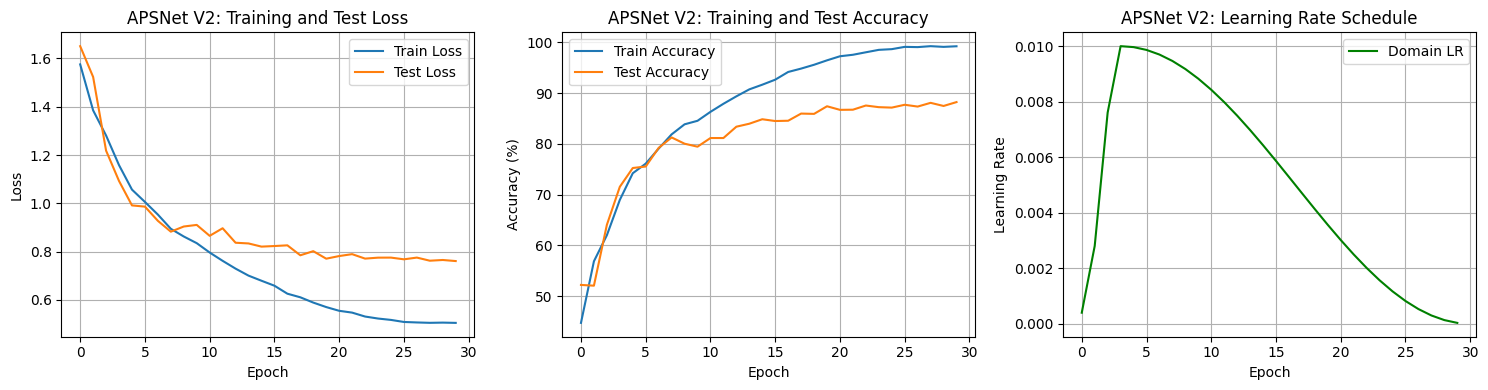


APSNet V2 Final Results:
Best Test Accuracy: 88.25%
Final Train Accuracy: 99.25%
Final Test Accuracy: 88.25%


In [41]:
# Plot APSNet V2 training history
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Loss plot
axes[0].plot(apsnet_history['train_loss'], label='Train Loss')
axes[0].plot(apsnet_history['test_loss'], label='Test Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('APSNet V2: Training and Test Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy plot
axes[1].plot(apsnet_history['train_acc'], label='Train Accuracy')
axes[1].plot(apsnet_history['test_acc'], label='Test Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('APSNet V2: Training and Test Accuracy')
axes[1].legend()
axes[1].grid(True)

# Learning rate plot
axes[2].plot(apsnet_history['lr'], label='Domain LR', color='green')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Learning Rate')
axes[2].set_title('APSNet V2: Learning Rate Schedule')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.savefig('../models/apsnet_v2_training_history.png', dpi=150)
plt.show()

print(f"\nAPSNet V2 Final Results:")
print(f"Best Test Accuracy: {apsnet_best_acc:.2f}%")
print(f"Final Train Accuracy: {apsnet_history['train_acc'][-1]:.2f}%")
print(f"Final Test Accuracy: {apsnet_history['test_acc'][-1]:.2f}%")

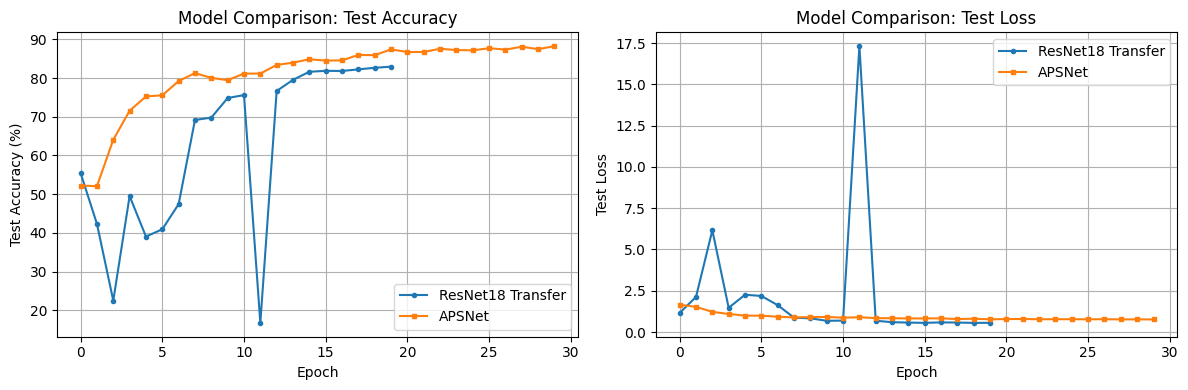


MODEL COMPARISON SUMMARY

ResNet18 (Transfer Learning):
  Best Test Accuracy: 82.96%
  Parameters: 11,180,616

APSNet (Domain-Specific Architecture):
  Best Test Accuracy: 88.25%
  Parameters: 69,049,514

Difference: +5.29%
APSNet outperforms ResNet18 baseline!


In [42]:
# Compare ResNet18 vs APSNet
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Test Accuracy comparison
axes[0].plot(history['test_acc'], label='ResNet18 Transfer', marker='o', markersize=3)
axes[0].plot(apsnet_history['test_acc'], label='APSNet', marker='s', markersize=3)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Test Accuracy (%)')
axes[0].set_title('Model Comparison: Test Accuracy')
axes[0].legend()
axes[0].grid(True)

# Test Loss comparison
axes[1].plot(history['test_loss'], label='ResNet18 Transfer', marker='o', markersize=3)
axes[1].plot(apsnet_history['test_loss'], label='APSNet', marker='s', markersize=3)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Test Loss')
axes[1].set_title('Model Comparison: Test Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('../models/model_comparison.png', dpi=150)
plt.show()

print("\n" + "=" * 60)
print("MODEL COMPARISON SUMMARY")
print("=" * 60)
print(f"\nResNet18 (Transfer Learning):")
print(f"  Best Test Accuracy: {best_acc:.2f}%")
print(f"  Parameters: {sum(p.numel() for p in model.parameters()):,}")

print(f"\nAPSNet (Domain-Specific Architecture):")
print(f"  Best Test Accuracy: {apsnet_best_acc:.2f}%")
print(f"  Parameters: {sum(p.numel() for p in apsnet_model.parameters()):,}")

improvement = apsnet_best_acc - best_acc
print(f"\nDifference: {improvement:+.2f}%")
if improvement > 0:
    print("APSNet outperforms ResNet18 baseline!")
else:
    print("ResNet18 baseline outperforms APSNet.")

Generating predictions: 100%|██████████| 107/107 [00:42<00:00,  2.51it/s]


CLASSIFICATION REPORT - APSNet V2
              precision    recall  f1-score   support

   Variety 1     0.9171    0.9108    0.9139       437
   Variety 2     0.9618    0.9527    0.9572       528
   Variety 3     0.8593    0.8968    0.8777       436
   Variety 4     0.8432    0.8513    0.8473       417
   Variety 5     0.8187    0.7278    0.7706       360
   Variety 6     0.8918    0.9111    0.9013       416
   Variety 7     0.8697    0.8741    0.8719       397
   Variety 8     0.8638    0.8932    0.8783       412

    accuracy                         0.8825      3403
   macro avg     0.8782    0.8772    0.8773      3403
weighted avg     0.8821    0.8825    0.8819      3403



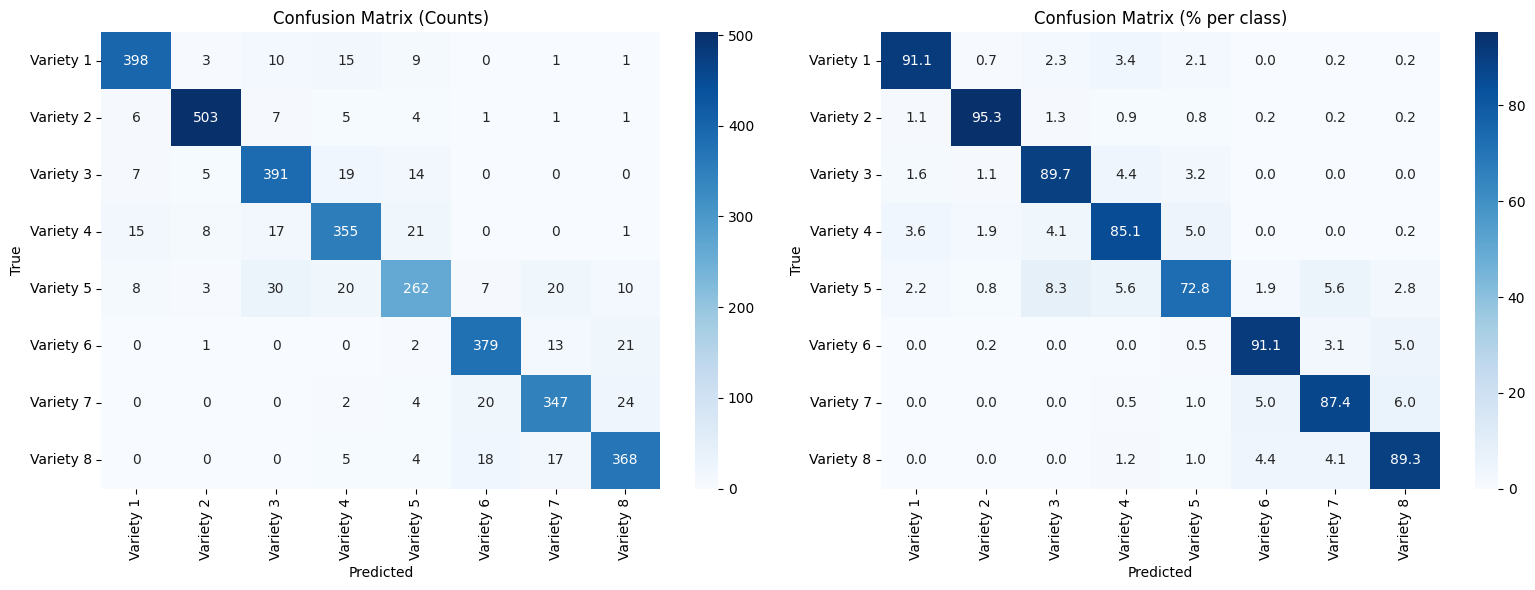


Per-Class Accuracy:
----------------------------------------
Variety 1: 91.08% (398/437)
Variety 2: 95.27% (503/528)
Variety 3: 89.68% (391/436)
Variety 4: 85.13% (355/417)
Variety 5: 72.78% (262/360)
Variety 6: 91.11% (379/416)
Variety 7: 87.41% (347/397)
Variety 8: 89.32% (368/412)
----------------------------------------
Overall Accuracy: 88.25%


In [43]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Load best APSNet V2 model
apsnet_model.load_state_dict(torch.load('../models/apsnet_v2_best.pth', map_location=device))
apsnet_model.eval()

# Collect all predictions and true labels
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Generating predictions"):
        images = images.to(device)
        outputs = apsnet_model(images)
        _, predicted = outputs.max(1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Class names (variety 1-8)
class_names = [f'Variety {i}' for i in range(1, 9)]

# Classification Report
print("=" * 70)
print("CLASSIFICATION REPORT - APSNet V2")
print("=" * 70)
print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, 
            yticklabels=class_names, ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')
axes[0].set_title('Confusion Matrix (Counts)')

# Normalized (percentages)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(cm_normalized, annot=True, fmt='.1f', cmap='Blues', xticklabels=class_names,
            yticklabels=class_names, ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')
axes[1].set_title('Confusion Matrix (% per class)')

plt.tight_layout()
plt.savefig('../models/apsnet_v2_confusion_matrix.png', dpi=150)
plt.show()

# Per-class accuracy summary
print("\nPer-Class Accuracy:")
print("-" * 40)
for i, name in enumerate(class_names):
    class_acc = cm[i, i] / cm[i].sum() * 100
    print(f"{name}: {class_acc:.2f}% ({cm[i, i]}/{cm[i].sum()})")

# Overall accuracy
overall_acc = np.trace(cm) / cm.sum() * 100
print("-" * 40)
print(f"Overall Accuracy: {overall_acc:.2f}%")